In [1]:
import os

import torch
from detr_config import Config
from detr_detection import plot_annotations, plot_results
from PIL import Image
from transformers import DetrImageProcessor

from detr_evaluation import load_best_model
from detr_dataset import get_dataset, get_dataloader

In [2]:
# version = 'model=DETR_backbone=resnet50_queries=50_dmodel=256_layers=6/fold_1'
version = 'balloon_model=DETR_backbone=resnet50_queries=100_dmodel=256_layers=6/fold_1'
model = load_best_model(version)
id2label = model.detr_model.config.id2label

image_processor = DetrImageProcessor()
# test_dir = os.path.join(Config.DATASET, 'test')
test_dir = './balloon/valid/'
test_dataset = get_dataset(test_dir, image_processor)
test_loader = get_dataloader(test_dataset, image_processor)

c:\ProgramData\miniconda3\envs\detr-env\Lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'detr_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['detr_model'])`.
  rank_zero_warn(


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
pixel_values, labels = test_dataset.__getitem__(6)
image_id = labels['image_id'].item()
image_data = test_dataset.coco.loadImgs(image_id)[0]

image = Image.open(os.path.join(test_dir, image_data['file_name']))
annotations = test_dataset.coco.imgToAnns[image_id]

with torch.no_grad():
    model.eval()
    outputs = model(
        pixel_values = pixel_values.unsqueeze(0),
        pixel_mask = torch.ones(1,800,800)
    )

postprocessed_outputs = image_processor.post_process_object_detection(
                            outputs, target_sizes=[(800, 800)], threshold=0.01, )

results = postprocessed_outputs[0]

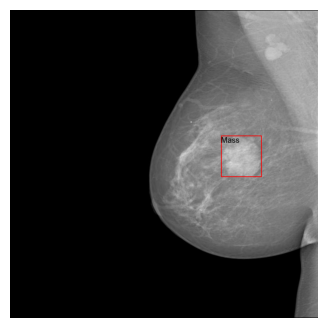

In [7]:
plot_annotations(image.copy(), annotations, id2label)


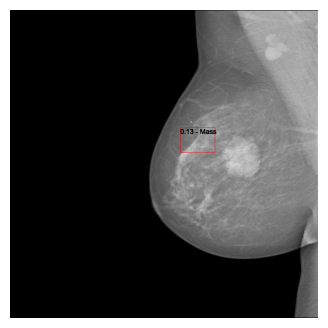

In [8]:
plot_results(image.copy(), results, id2label)